In [4]:
from compel import Compel, ReturnedEmbeddingsType
from diffusers import StableDiffusionPipeline
import torch


DEVICE='mps'

In [11]:
runway = "runwayml/stable-diffusion-v1-5"
fast_sdxl = "prodia/sdxl-stable-diffusion-xl"

In [12]:
pipe = StableDiffusionPipeline.from_pretrained(runway, torch_dtype=torch.float16).to(DEVICE)
#pipe.load_lora_weights('pytorch_lora_weights.safetensors')
pipe.safety_checker = None
pipe.requires_safety_checker = False
compel = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [49]:
generation_dict = {
    "street": {
        "type": "concrete",
        "intensity":" "#None
    },
    "weather":{
        "type":"foggy",
        "intensity": " "#None
    },
    "background":{
        "type": "urban",
        "intensity": " "#None
    },
    "obstacles":{
        "type": " ",
        "intensity": " "#None
    },
    "congestion": "low",
    "time": "night",
}

In [13]:
from compel import Compel

compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)

In [14]:
w1, w2 = 2,0.5

In [21]:
prompt = f'["running Cat","wearing a hat"].and({w1},0.5)'
final = compel(prompt)

In [50]:
def generate_prompt(generation_dict):
    prompt = f'Indian road,low camera angle, {generation_dict["street"]["type"]}{generation_dict["street"]["intensity"]}street, {generation_dict["weather"]["type"]}{generation_dict["weather"]["intensity"]} weather,Indian {generation_dict["background"]["type"]}{generation_dict["background"]["intensity"]} background,{generation_dict["obstacles"]["type"]}{generation_dict["obstacles"]["intensity"]} obstacle,{generation_dict["congestion"]} congestion traffic,{generation_dict["time"]} time'
    return prompt

In [17]:
# prompt = "An indian road in a jungle at night, with a single road with two lanes going down the middle and dark forests on both sides"#generate_prompt(generation_dict = generation_dict)
# conditioning = compel(prompt)
negative_prompt = "cartoon, satellite"
negative_conditioning = compel(negative_prompt)
# or: conditioning = compel([prompt])

In [61]:
prompt

'An indian road in a jungle at night, with a single road with two lanes going down the middle and dark forests on both sides'

In [62]:
negative_prompt_embeds=negative_conditioning

'negative_prompt_embeds=negative_conditioning'

  0%|          | 0/50 [00:00<?, ?it/s]

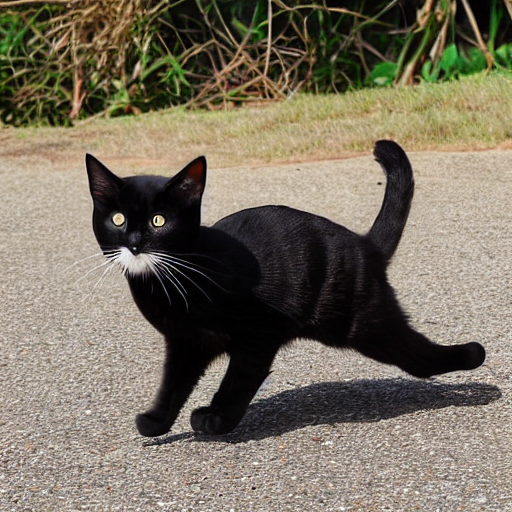

In [22]:
# generate image
image = pipe(prompt_embeds=final, negative_prompt_embeds=negative_conditioning, num_inference_steps=30, output_type="pil").images[0]
image

In [57]:
from diffusers import StableDiffusionImg2ImgPipeline

In [58]:
device = "mps"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
refiner_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
refiner_pipe = refiner_pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/37 [00:00<?, ?it/s]

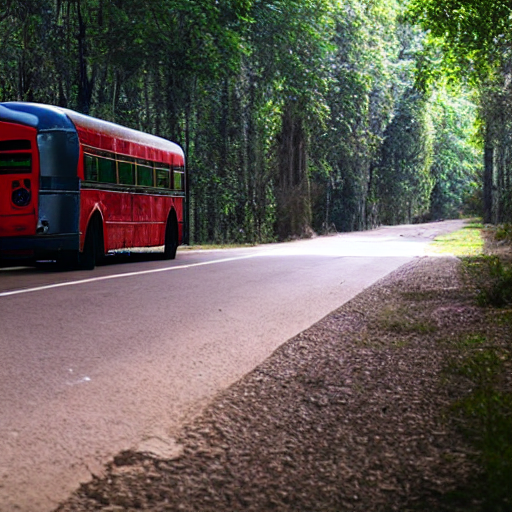

In [64]:
image = refiner_pipe(prompt="Refine the image with characteristics like cars, buses, people", image=image, strength=0.75, guidance_scale=7.5).images[0]
image

In [25]:
type(image)

PIL.Image.Image

In [27]:
import numpy as np
np.array(image)

array([[[ 20,  13,  10],
        [ 16,  12,   6],
        [ 29,  21,  14],
        ...,
        [121, 110, 109],
        [121, 108, 110],
        [123, 111, 111]],

       [[ 26,  22,  13],
        [ 24,  20,  12],
        [ 27,  18,  16],
        ...,
        [122, 110, 110],
        [121, 110, 110],
        [122, 109, 110]],

       [[ 23,  17,  11],
        [ 25,  17,  14],
        [ 21,  14,  13],
        ...,
        [123, 111, 111],
        [122, 111, 111],
        [122, 109, 110]],

       ...,

       [[ 52,  39,  33],
        [ 52,  38,  34],
        [ 57,  44,  40],
        ...,
        [160, 134, 120],
        [ 92,  72,  61],
        [ 53,  38,  33]],

       [[ 50,  35,  31],
        [ 51,  36,  34],
        [ 51,  37,  35],
        ...,
        [166, 132, 123],
        [ 80,  55,  45],
        [ 65,  48,  38]],

       [[ 49,  36,  34],
        [ 49,  36,  33],
        [ 50,  37,  32],
        ...,
        [172, 149, 127],
        [113,  85,  68],
        [ 79,  65,  55]]

In [69]:
from diffusers import DiffusionPipeline
import torch

n_steps = 40
high_noise_frac = 0.8

runway = "runwayml/stable-diffusion-v1-5"

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", 
    #torch_dtype=torch.float16, 
    variant="fp16", 
    use_safetensors=True
)

pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)


refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=pipe.text_encoder_2,
    vae=pipe.vae,
    #torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)

refiner.unet = torch.compile(refiner.unet, mode="reduce-overhead", fullgraph=True)


prompt = f'Generate a Photorealistic image of an indian road with defined sharp edges from a driver point of view,low camera angle, with these characteristics {generation_dict["street"]["type"]}{generation_dict["street"]["intensity"]}street, {generation_dict["weather"]["type"]}{generation_dict["weather"]["intensity"]} weather,Indian {generation_dict["background"]["type"]}{generation_dict["background"]["intensity"]} background,{generation_dict["obstacles"]["type"]}{generation_dict["obstacles"]["intensity"]} obstacle,{generation_dict["congestion"]} traffic,{generation_dict["time"]} time'
negative_prompt = "A game scene, a cartoon drawing,cartoon, satellite,game"

image = pipe(prompt=prompt,negative_prompt=negative_prompt,num_inference_steps=n_steps,
    denoising_end=high_noise_frac, output_type="latent").images[0]
image = refiner(prompt=prompt,negative_prompt=negative_prompt,num_inference_steps=n_steps,
    denoising_start=high_noise_frac, image=image[None, :]).images[0]

image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 